# Online Retail K-means & Hierarchical Clustering

Fullname: Bùi Lê Hải Triều

StudentID: 20133101

## Khai báo các thư viện cần thiết 

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

## Load dữ liệu vào dataframe 

In [213]:
df = pd.read_csv("D:\Data Mining\Demo Clustering K-Mean/OnlineRetail.csv", delimiter=',', encoding = "ISO-8859-1")

## Quan sát dữ liệu 

In [214]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Giới thiệu về dataset: Đây là một bộ dữ liệu quốc tế chứa tất cả các giao dịch xảy ra từ ngày 01/12/2010 đến 09/12/2011 của một cửa hàng bán lẻ trực tuyến không có cửa hàng vật lý đặt tại Vương quốc Anh. Dữ liệu gồm 8 cột và 541909 dòng
Các thuộc tính:
- InvoiceNo: Số hóa đơn
- StockCode: Mã sản phẩm
- Description: Tên sản phẩm
- Quantity: Số lượng của mỗi sản phẩm có trong một hóa đơn (một giao dịch)
- InvoiceDate: Thời gian thực hiện giao dịch
- UnitPrice: Đơn giá
- CustomerID: Số khách hàng
- Country: Tên quốc gia

## 1. Chuẩn bị dữ liệu
Data Cleaning


In [215]:
#Tính tổng các dòng có giá trị Nan của từng cột
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Loại bỏ các giá trị NaN trong tập dữ liệu 

In [216]:
df.dropna(inplace=True)

In [217]:
df.count()
#hiển thị kết quả sau khi loại bỏ các giá trị NaN

InvoiceNo      406829
StockCode      406829
Description    406829
Quantity       406829
InvoiceDate    406829
UnitPrice      406829
CustomerID     406829
Country        406829
dtype: int64

## 2. Tạo Similarity Metric


### 2.1 Tổng số tiền chi (Amount)
Tạo một dataframe từ dataframe ban đầu nhưng chỉ lấy cột CustomerID và thêm cột Amount (Quantity*UnitPrice) để biết tổng số tiền chi của từng khách hàng

In [218]:
#trước tiên thêm 1 cột Amount vào dataframe ban đầu để tính tổng tiền cho từng sản phẩm trong mỗi hóa đơn
df['Amount']=df['Quantity']*df['UnitPrice']

#Bắt đầu tạo dataframe mới bao gồm CustomerID và Amount 
each_customer=df.groupby('CustomerID')['Amount'].sum()  #Nhóm Amount theo CustomerID và tính tổng số tiền chi của từng khách hàng 
each_customer=each_customer.reset_index()  #reset các index trong dataframe mới
each_customer.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### 2.2 Số lượng giao dịch (Number of Transactions)
Tạo một dataframe mới từ dataframe ban đầu gồm 2 cột CustomerID và Invoice, trong đó Invoice là tổng số lần khách hàng thực hiện giao dịch

In [219]:
#Tạo dataframe mới
each_customer_freq=df.groupby('CustomerID')['InvoiceNo'].count() #Nhóm Invoice theo CustomerID và tính tổng số hóa đơn của từng khách hàng 
each_customer_freq=each_customer_freq.reset_index()  #reset các index trong dataframe mới
each_customer_freq

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


### 2.3 Lần cuối giao dịch (Last transaction)
Tạo một dataframe mới gồm 2 cột CustomerID và last_transaction, trong đó last_transaction là số ngày tính từ lần giao dịch gần nhất của khách hàng.


last_transaction sẽ được tính bằng cách lấy giá trị ngày lớn nhất (gần nhất) của cột InvoiceDate trừ cho ngày gần nhất mà khách hàng thực hiện giao dịch.

In [220]:
#vì cột InvoiceDate đang ở dạng string nên để thực hiện được phép tính thì trước hết cần đổi về dạng datetime 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

#tìm ngày gần nhất của cột InvoiceDate
max_date=max(df['InvoiceDate'])
max_date

#tạo cột last_transaction trong dataframe ban đầu
df['last_transaction']= max_date - df['InvoiceDate']

#tạo dataframe mới 
import datetime as dt
each_customer_lasttime=df.groupby(df['CustomerID']).min()['last_transaction']
each_customer_lasttime=each_customer_lasttime.reset_index()
each_customer_lasttime['last_transaction']=each_customer_lasttime['last_transaction'].dt.days #thực hiện đổi các giá trị datetime sang số ngày (int)
each_customer_lasttime

,CustomerID,last_transaction
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
4367,18280.0,277
4368,18281.0,180
4369,18282.0,7
4370,18283.0,3


## Kết hợp các dataframe mới vừa tạo

In [221]:
#Đầu tiên kết hợp 2 dataframe chứa tổng tiền chi và số lần giao dịch 
df_new=pd.merge(each_customer,each_customer_freq,how='inner',on='CustomerID') #kết hợp theo kiểu inner chỉ lấy phần trùng là CustomerID

#Tiếp tục kết hợp dataframe vừa tạo với dataframe có chứa cột last_transaction
df_new=pd.merge(df_new,each_customer_lasttime,how='inner',on='CustomerID') 
df_new

,CustomerID,Amount,InvoiceNo,last_transaction
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
...,...,...,...,...
4367,18280.0,180.60,10,277
4368,18281.0,80.82,7,180
4369,18282.0,176.60,13,7
4370,18283.0,2094.88,756,3


## Loại bỏ các outliers
Để đạt được kết quả phân cụm tốt nhất cần phải loại bỏ các outliers có thể làm lệch dataset.

Trước hết ta sẽ sử dụng đồ thị boxplot để phân tích các outliers của 3 cột Amount, InvoiceNo và last_transaction

Text(0.5, 0, 'Attributes')

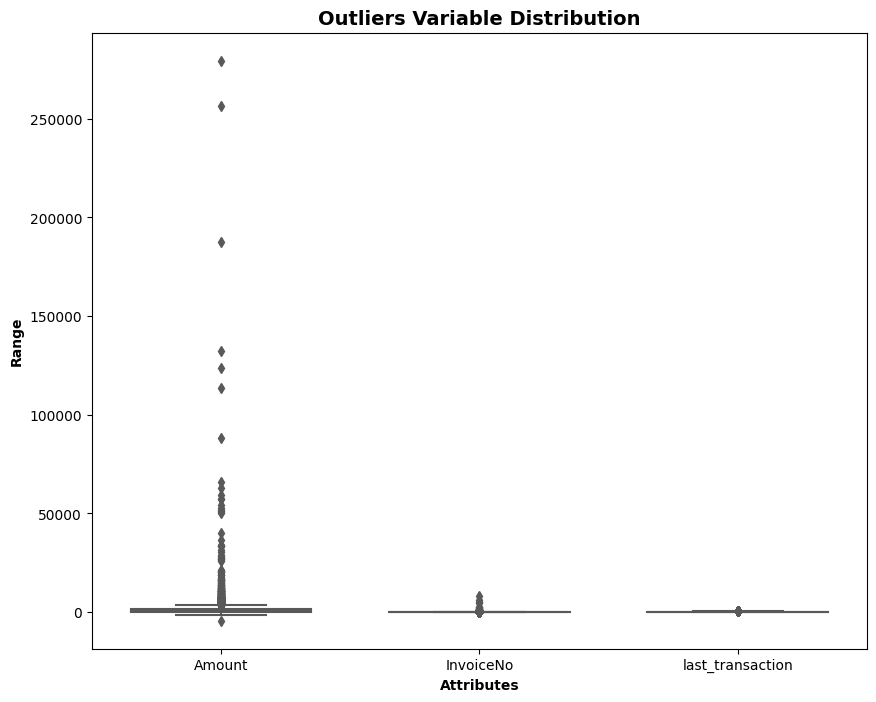

In [222]:
attributes = ['Amount','InvoiceNo','last_transaction']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_new[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
#setting các tiêu đề, font chữ và tên cột x,y
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Biểu đồ thể hiện sự phân bố của các giá trị của 3 cột. 

Dễ thấy cột Amount xuất hiện khá nhiều outliers tuy nhiên ta vẫn sẽ thực hiện loại bỏ outliers trong cả 3 cột để đảm bảo kết quả tốt nhất của cluster

Ta sẽ sử dụng phương pháp thống kê IQR để loại bỏ outliers:

Tứ phân vị là đại lượng mô tả sự phân bố và sự phân tán của tập dữ liệu. Tứ phân vị có 3 giá trị, đó là tứ phân vị thứ nhất Q1 (25th), thứ hai Q2 (50th) hay median, và thứ ba Q3 (75th). Ba giá trị này chia một tập hợp dữ liệu (đã sắp xếp dữ liệu theo trật từ từ bé đến lớn) thành 4 phần có số lượng quan sát đều nhau. Tứ phân vị được xác định như sau:

-Sắp xếp các số theo thứ tự tăng dần
-Cắt dãy số thành 4 phàn bằng nhau
-Tứ phân vị là các giá trị tại vị trí cắt

IQR là mức chênh lệch giữa tứ phân vị thứ nhất Q1 và tứ phân vị thứ ba Q3:

                                IQR=Q3−Q1

Giá trị IQR có thể sử dụng để xác định outliers bằng cách thiết lập các giá trị biên Upper/Lower : Nếu chúng ta trừ đi k*IQR từ tứ phân vị đầu tiên Q1, bất kỳ giá trị dữ liệu nào nhỏ hơn con số này được coi là giá trị outliers. Tương tự như vậy, nếu chúng ta thêm k*IQR đến tứ phân vị thứ ba Q3, bất kỳ giá trị dữ liệu nào lớn hơn con số này được coi là outliers. Giá trị k thường được chọn là 1.5.

Trong phần này, ta chọn Q1 5% và Q3 95%, kết quả của nó sẽ cho ta giá trị của 5% phân bố đầu của cột dữ liệu và tương tự cho 95%. 

                                Upper_bound(giá trị biên trên)= Q3 + 1.5 * IQR
                                Lower_bound(giá trị biên dưới)= Q1 - 1.5 * IQR

In [223]:
#loại bỏ outliers ở cột Amount
Q1 = df_new.Amount.quantile(0.05) #xác định tứ phân vị đầu
Q3 = df_new.Amount.quantile(0.95) #xác định tứ phân vị thứ 3
IQR = Q3 - Q1 #tính IQR
df_new = df_new[(df_new.Amount >= Q1 - 1.5*IQR) & (df_new.Amount <= Q3 + 1.5*IQR)] #loại bỏ các giá trị ở cột Amount mà bé hơn giá trị biên dưới và lớn hơn biên trên


# Thực hiện loại bỏ outliers ở các cột khác tương tự như cột Amout
# loại bỏ outliers ở cột last_transaction
Q1 = df_new.last_transaction.quantile(0.05)
Q3 = df_new.last_transaction.quantile(0.95)
IQR = Q3 - Q1
df_new = df_new[(df_new.last_transaction >= Q1 - 1.5*IQR) & (df_new.last_transaction <= Q3 + 1.5*IQR)]

# loại bỏ outliers ở cột InvoiceNo
Q1 = df_new.InvoiceNo.quantile(0.05)
Q3 = df_new.InvoiceNo.quantile(0.95)
IQR = Q3 - Q1
df_new = df_new[(df_new.InvoiceNo >= Q1 - 1.5*IQR) & (df_new.InvoiceNo <= Q3 + 1.5*IQR)]

## Data Scaling

Ta sẽ sử dụng phương pháp Standardisation Scaling để scale data

In [224]:
#Khai báo các thư viện cần thiết 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Lấy 3 cột để scaling
df_scaled=df_new[['Amount', 'InvoiceNo', 'last_transaction']]
#df_scaled.head()
#fit transform
df_scaled=StandardScaler().fit_transform(df_scaled)


#df_scaled sẽ trả về 1 mảng do đó ta sẽ đưa nó về dạng dataframe
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['Amount', 'InvoiceNo', 'last_transaction']
df_scaled.head()


,Amount,InvoiceNo,last_transaction
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## 3. Xây dựng mô hình K-Mean Clustering

K-means clustering sẽ bao gồm workflow như sau:

1. Chọn ngẫu nhiên K tâm (centroid) cho K cụm (cluster). Mỗi cụm được đại diện bằng các tâm của cụm.
2. Tính khoảng cách giữa các đối tượng (objects) đến K tâm 
3. Nhóm các đối tượng vào nhóm gần nhất
4. Xác định lại tâm mới cho các nhóm

### Chọn ngẫu nhiên một số K

Ở đây ta sẽ chọn k=5

In [225]:
kmeans = KMeans(n_clusters=5, max_iter=50) #Khởi tạo Kmeans với số cụm là 5 và số lần lặp tối đa là 50
kmeans.fit(df_scaled) #hàm fit sẽ thực hiện training data trong df_scaled

kmeans.labels_

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 1, 4, ..., 0, 4, 4])

### Tìm số K tối ưu cho thuật toán

Trong phần này, ta sẽ sử dụng 2 phương pháp để tìm số K cluster tối ưu nhất cho thuật toán:
1. Elbow Curve
2. Silhouette Analysis


#### Elbow Curve 

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

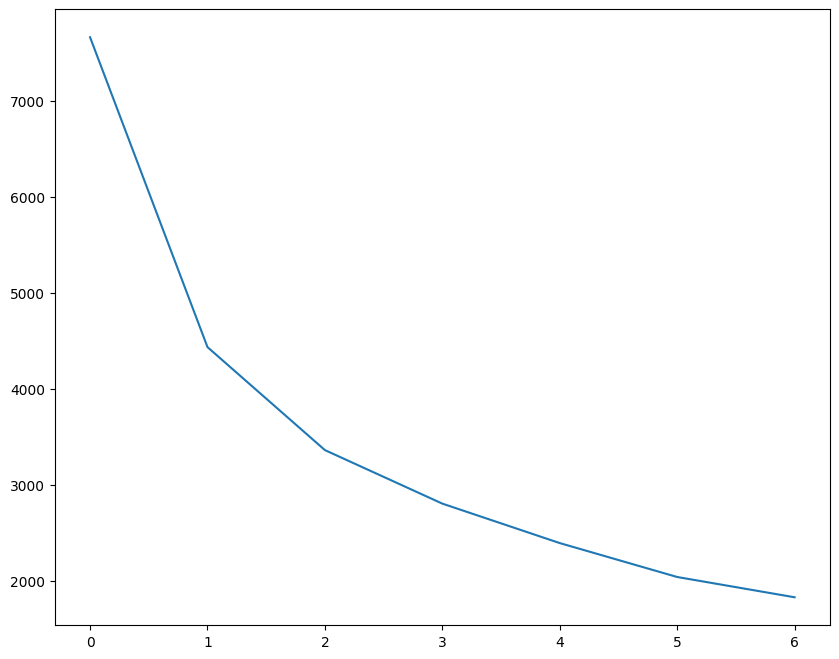

In [226]:
# Elbow-curve/SSD

ssd = [] # khởi tạo danh sách trống để lưu trữ các  tổng bình phương khoảng cách (sum of squared distance) cho mỗi giá trị k khác nhau
range_n_clusters = [2, 3, 4, 5, 6, 7, 8] #khởi tạo các giá trị cho K cluster
for num_clusters in range_n_clusters: # vòng lặp với mỗi giá trị k từ 2 đến 8
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)
    
    ssd.append(kmeans.inertia_) #hàm inertia tính tổng bình phương khoảng cách của mô hình vừa train 
    
# Biểu diễn các giá trị ssd theo Elbow Curve
plt.plot(ssd)

Để chọn được số k từ đồ thị Elbow ta sẽ quan sát ở điểm mà đồ thị bắt đầu thoải (giảm tuyến tính).

Ở đây ta chọn k = 3 

Giải thích thêm : Elbow method dựa trên giả định khi càng có nhiều cluster, thì có nghĩa các điểm dữ liệu giống nhau đã được gom cụm, mỗi cụm sẽ chỉ có ít điểm dữ liệu bên trong, và những điểm này sẽ ko nằm xa nhau, do đó SSE sẽ giảm, khi k tăng. Tuy nhiên khi k càng tăng chúng ta sẽ càng có nhiều cluster cần phân tích, dẫn đến không hiệu quả. Do đó chúng ta nên chon số k mà ở đó SSE bắt đầu giảm đều.

Ref: towardsdatasciene.com

### Silhouette Analysis

Để củng cố sự chính xác thì ta sẽ áp dụng thêm phương pháp Silhouette

Phương pháp Silhouette  sẽ cho chúng ta biết những điểm dữ liệu hay những quan sát nào nằm gọn bên trong cụm (tốt) hay nằm gần ngoài rìa cụm (không tốt) để đánh giá hiệu quả phân cụm.

Silhouette đo lường khoảng cách của một điểm dữ liệu trong cụm đến Centroid, điểm trung tâm của cụm, và khoảng cách của chính điểm đó đến điểm trung tâm của cụm gần nhất (hoặc đến các điểm trung tâm của các cụm còn lại, và chọn ra khoảng cách ngắn nhất). Đó là trường hợp đo lường cho K-means clustering.

Silhouette là phương pháp tính toán kết hợp đánh giá cả Cohesion (qua ai) và Separation (bi). Nếu Silhouette tiến về -1, tức khoảng cách điểm i so với điểm trung tâm trong chính cụm nó được phân xa hơn so với điểm trung tâm của cụm còn lại, vậy khả năng điểm i lúc này bị phân sai cụm. 

Cách đánh giá dựa trên Silhouette Score:
- Điểm trung bình Silhouette từ 0.5 trở lên, bằng chứng cho thấy có thể cluster này sát với thực tế
- Điểm trung bình Silhouette từ 0.25 đến 0.5, thì cần thêm kiến thức chuyên môn, kinh nghiệm để đánh giá thêm khả năng cluster có trong thực tế
- Điểm trung bình dưới 0.25, thì không nên tin tưởng cluster, và cần đi tìm nhiều bằng chứng khác.

ref: "Data mining and Predictive analytics” của nhà xuất bản Wiley:

In [227]:
#import thư viện cần dùng
from sklearn.metrics import silhouette_score
from IPython.display import display
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
#tạo vòng lặp thực hiện tính điểm trung bình Silhouette của từng lần thực thi thuật toán Kmeans cùng số K cluster tương ứng
for num_clusters in range_n_clusters:
    
    # khởi tạo kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)
    
    cluster_labels = kmeans.labels_ #gán mảng giá trị cluster tương ứng 
    
    # silhouette score
    silhouette_avg_ = silhouette_score(df_scaled, cluster_labels) #thực hiện tính điểm trung bình Silhouette trong dataframe df_scaled với số cụm được truyền vào
    display(silhouette_avg_) 
   

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.5411246404292333

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.5084896296141937

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.48199592314697204

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.4638787576606892

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.41759340426856373

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.4159527413129758

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.4091685530902161

Các kết quả thể hiện lần lượt giá trị của điểm trung bình Silhouette từ k=2 -> k=8

Kết hợp với biểu đồ Elbow ở trên ta có thể chọn được k=3 là số K cluster tối ưu nhất cho mô hình

## Final Model


In [236]:
#final model với k=3

kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_scaled)



# kết hợp tên cụm vào dataframe df_new, kmeans.labels gọi ra 1 mảng chứa tên cụm của từng khách hàng trong dataframe df_new
df_new['Cluster_Id'] = kmeans.labels_
df_new.head()

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Amount,InvoiceNo,last_transaction,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


## Trực quan hóa dữ liệu sau khi hoàn thành model

Dùng box plot để trực quan các cụm với các cột simalarity metric 

<Axes: xlabel='Cluster_Id', ylabel='Amount'>

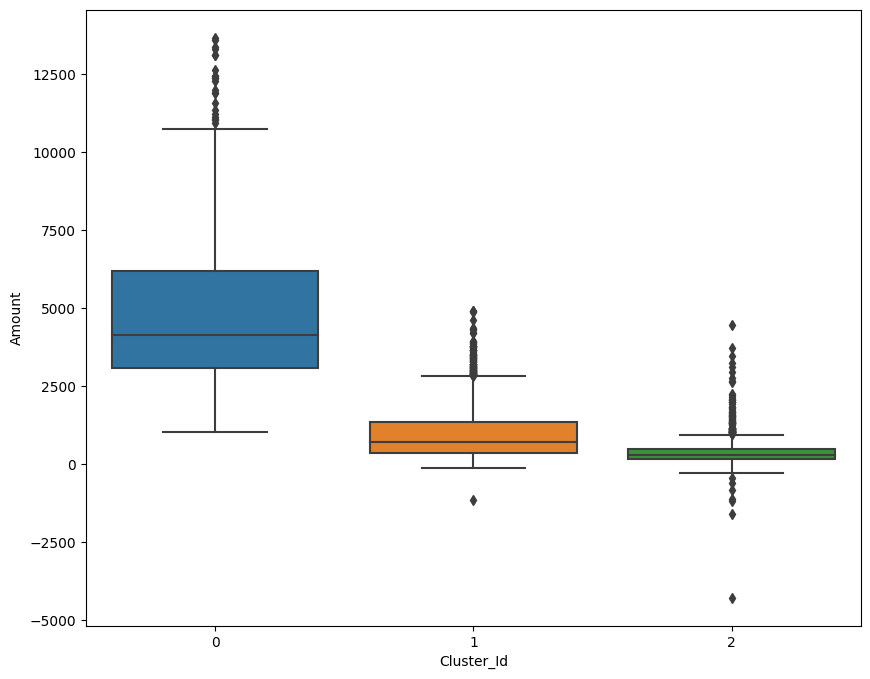

In [237]:
# Cluster và Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=df_new)

<Axes: xlabel='Cluster_Id', ylabel='InvoiceNo'>

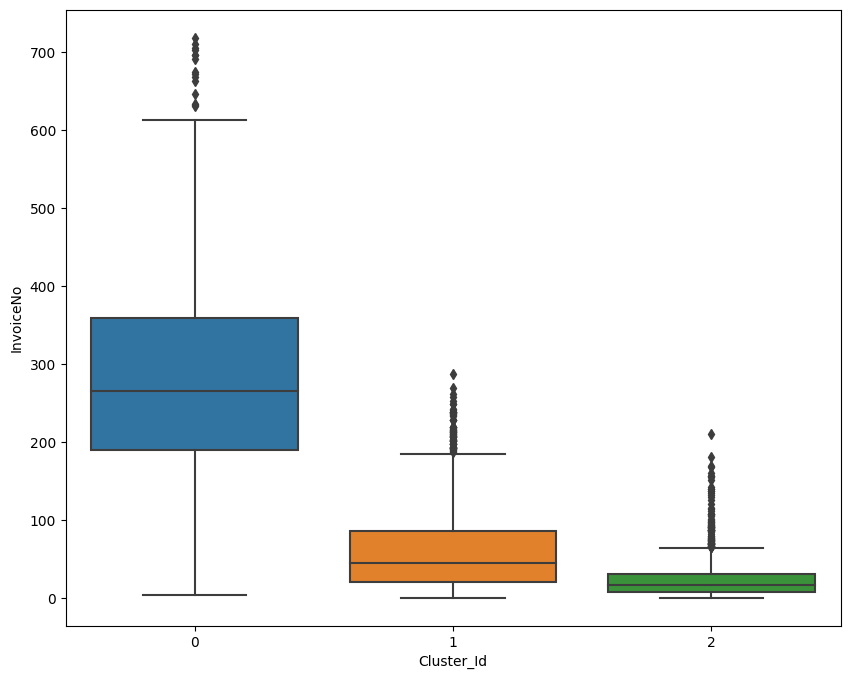

In [238]:
#  Cluster Id vs InvoiceNo

sns.boxplot(x='Cluster_Id', y='InvoiceNo', data=df_new)

<Axes: xlabel='Cluster_Id', ylabel='last_transaction'>

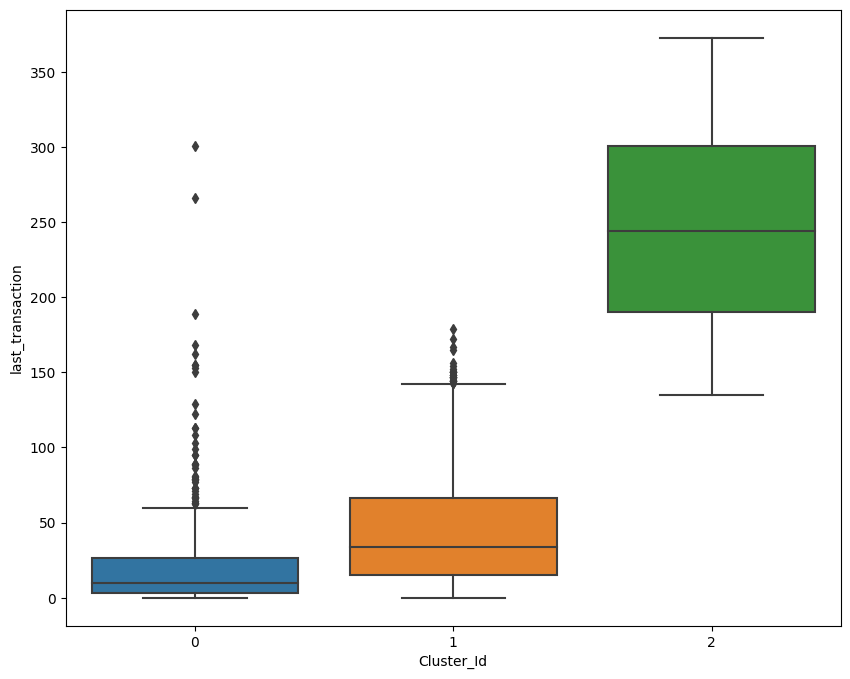

In [239]:
# Cluster Id vs last_transaction

sns.boxplot(x='Cluster_Id', y='last_transaction', data=df_new)